## _______________________________________________________________________________________
# **Maestría en Inteligencia Artificial Aplicada**

## **Curso:** Análisis de Grandes Volumnes de Datos

### Tecnológico de Monterrey

## **Actividad 5:** Actividad de visualización de resultados

## **Objetivo:** Identificar métricas para la medición de la calidad de resultados derivados de la aplicación de modelos de aprendizaje. 

| Nombre    | Matricula |
| :-------- | :-------- |
| Armando de Jesús Cerda de la Rosa  | A01570376 |
| Isaura Yutsil Flores Escamilla | A01796552 |


## _______________________________________________________________________________________

# **0. Recapitulación de los resultados obtenidos de la *Actividad 4***

### **0.1) Configuración del entrono de desarrollo**

In [1]:
## Carga de paqueterías

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from builtins import max as maximum
from builtins import min as minimum

from pyspark.sql.types import DoubleType, FloatType

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, when, isnan, isnull, count, avg, stddev, min, max,
    sum as spark_sum, lit, rand, monotonically_increasing_id,
    concat_ws
)
from pyspark.sql.types import DoubleType, IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    VectorAssembler, StandardScaler, StringIndexer, 
    OneHotEncoder, Imputer
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator, 
    MulticlassClassificationEvaluator,
    ClusteringEvaluator
)
from pyspark.ml.stat import Correlation

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import pandas as pd

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql import DataFrame
from pyspark.sql.functions import rand
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
    .appName("Actividad3_AprendizajeSupervisadoNoSupervisado") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

print(f"Versión de Spark: {spark.version}")
print(f"SparkContext inicializado: {spark.sparkContext}")
print(f"Interfaz web disponible en: {spark.sparkContext.uiWebUrl}")

25/06/17 19:13:21 WARN Utils: Your hostname, MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.72 instead (on interface en0)
25/06/17 19:13:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/17 19:13:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Versión de Spark: 3.5.4
SparkContext inicializado: <SparkContext master=local[*] appName=Actividad3_AprendizajeSupervisadoNoSupervisado>
Interfaz web disponible en: http://192.168.1.72:4040


## **0.2) Carga de la base**

In [3]:
print("\n--- Paso 1: Lectura y primera limpieza de la base ---")

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "12g") \
    .appName('my-cool-app') \
    .getOrCreate()

#spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("sparl.sql.repl.eagerEval.enabled", True)
spark

file_paths = ["/Users/damian/Documents/Archivos_Yutsil/Codigos/archive (5)/Combined_Flights_2018.csv", 
              "/Users/damian/Documents/Archivos_Yutsil/Codigos/archive (5)/Combined_Flights_2019.csv"] 
              #"/Users/damian/Documents/Archivos_Yutsil/Codigos/archive (5)/Combined_Flights_2020.csv", 
              #"/Users/damian/Documents/Archivos_Yutsil/Codigos/archive (5)/Combined_Flights_2021.csv"]     


print("\n--- Paso 2: Lectura del primer archivo ---")
df_original = spark.read.csv(file_paths[0], header=True, inferSchema=True)

print("\n--- Paso 3: Proceso para lectura y merge del resto de los archivos ---")
for path in file_paths[1:]:
    df = spark.read.csv(path, header=True, inferSchema=True)
    df_original = df_original.unionByName(df)

print(f"Registros totales: {df_original.count():,}")
print(f"Variables disponibles: {len(df_original.columns)}")

df_original.show()



--- Paso 1: Lectura y primera limpieza de la base ---


25/06/17 19:13:23 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.



--- Paso 2: Lectura del primer archivo ---



--- Paso 3: Proceso para lectura y merge del resto de los archivos ---


25/06/17 19:13:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Registros totales: 13,781,196
Variables disponibles: 61
+----------+-----------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|          Airline|Origin|Dest|Cancelled|Diverted|

### **0.3) Construcción de la muestra M**

In [4]:
# Se implementa muestreo estratificado para garantizar representatividad
# Las variables de estratificación se basan en el análisis exploratorio previo

df_categorized = df_original.withColumn(
    "Temporada",
    when((col("Month") >= 6) & (col("Month") <= 8), "Alta").otherwise("Baja")
).withColumn(
    "TipoDia",
    when((col("DayOfWeek") >= 6), "FinDeSemana").otherwise("Laborable")
).withColumn(
    "CategoriaDistancia",
    when(col("Distance").isNull(), "Desconocido")
    .when(col("Distance") < 500, "Corto")
    .when(col("Distance") < 1500, "Medio")
    .otherwise("Largo")
)

df_strata = df_categorized.withColumn(
    "Estrato",
    concat_ws("_", col("Temporada"), col("TipoDia"), col("CategoriaDistancia"))
)

print("Distribución de estratos identificados")
strata_dist = df_strata.groupBy("Estrato").count().orderBy("count", ascending=False)
strata_dist.show(20)

total_records = df_strata.count()
target_sample_size = minimum(50000, total_records)
sampling_fraction = target_sample_size / total_records

print(f"Fracción de muestreo aplicada: {sampling_fraction:.4f}")

df_sample = df_strata.sampleBy("Estrato", 
                               fractions={row["Estrato"]: sampling_fraction 
                                         for row in strata_dist.collect()}, 
                               seed=42)

sample_count = df_sample.count()
print(f"\nMuestra M obtenida: {sample_count:,} registros")
print(f"Representatividad: {(sample_count/total_records)*100:.2f}% del dataset original")

Distribución de estratos identificados


25/06/17 19:13:40 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+--------------------+-------+
|             Estrato|  count|
+--------------------+-------+
|Baja_Laborable_Medio|3706116|
|Baja_Laborable_Corto|3134786|
|Baja_FinDeSemana_...|1362815|
|Alta_Laborable_Medio|1160282|
|Baja_FinDeSemana_...|1068252|
|Alta_Laborable_Corto| 964613|
|Baja_Laborable_Largo| 863283|
|Alta_FinDeSemana_...| 447691|
|Alta_FinDeSemana_...| 341500|
|Baja_FinDeSemana_...| 327789|
|Alta_Laborable_Largo| 290492|
|Alta_FinDeSemana_...| 113577|
+--------------------+-------+



Fracción de muestreo aplicada: 0.0036



Muestra M obtenida: 50,140 registros
Representatividad: 0.36% del dataset original


### **0.4) Preparación de los Datos**

Se procede a aplicar las estrategias de limpieza y transformación necesarias sobre la muestra M para adecuarla a los requerimientos de los algoritmos de machine learning que se implementarán

In [5]:
print("Análisis de completitud de datos en variables clave")

key_columns = [
    "ArrDelay", "DepDelay", "Distance", "AirTime", "CRSDepTime", 
    "CRSArrTime", "Cancelled", "Diverted", "CarrierDelay", 
    "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"
]

null_analysis = []
for col_name in key_columns:
    if col_name in df_sample.columns:
        data_type = [field.dataType for field in df_sample.schema.fields if field.name == col_name][0]
        if isinstance(data_type, (DoubleType, FloatType)):
            null_count = df_sample.filter(col(col_name).isNull() | isnan(col(col_name))).count()
        else:
            null_count = df_sample.filter(col(col_name).isNull()).count()
        null_percentage = (null_count / sample_count) * 100
        null_analysis.append((col_name, null_count, null_percentage))

null_summary = pd.DataFrame(null_analysis, columns=['Variable', 'Valores_Nulos', 'Porcentaje'])
null_summary = null_summary.sort_values('Porcentaje', ascending=False)
print(null_summary.to_string(index=False))

Análisis de completitud de datos en variables clave


  Variable  Valores_Nulos  Porcentaje
   AirTime           1020    2.034304
  ArrDelay            993    1.980455
  DepDelay            827    1.649382
  Distance              0    0.000000
CRSDepTime              0    0.000000
CRSArrTime              0    0.000000
 Cancelled              0    0.000000
  Diverted              0    0.000000


In [6]:
# from pyspark.sql.types import DoubleType, FloatType

# data_type = [field.dataType for field in df_sample.schema.fields if field.name == col_name][0]

# col_obj = col(col_name)

# if isinstance(data_type, (DoubleType, FloatType)):
#     null_count = df_sample.filter(col_obj.isNull() | isnan(col_obj)).count()
# else:
#     null_count = df_sample.filter(col_obj.isNull()).count()

In [7]:
print("Implementando estrategias de limpieza de datos")

# Se excluyen vuelos cancelados y desviados ya que no aplican para el análisis de retrasos
df_cleaned = df_sample.filter(
    (col("Cancelled") != 1) & (col("Diverted") != 1)
)

print(f"Registros tras filtrado de vuelos cancelados/desviados: {df_cleaned.count():,}")

# Las variables de retraso específico presentan nulos cuando no hay retraso atribuible a esa causa
delay_columns = ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]
for col_name in delay_columns:
    if col_name in df_cleaned.columns:
        df_cleaned = df_cleaned.fillna({col_name: 0})

# Se eliminan registros con valores faltantes en variables esenciales para el modelado
critical_columns = ["ArrDelay", "DepDelay", "Distance", "CRSDepTime", "CRSArrTime"]
df_cleaned = df_cleaned.dropna(subset=critical_columns)

print(f"Registros finales tras limpieza: {df_cleaned.count():,}")

# Se generan variables derivadas de utilidad para el análisis
df_cleaned = df_cleaned.withColumn("DepHour", (col("CRSDepTime") / 100).cast(IntegerType())) \
                      .withColumn("ArrHour", (col("CRSArrTime") / 100).cast(IntegerType()))

# Variable objetivo binaria para clasificación
df_cleaned = df_cleaned.withColumn(
    "DelayedFlag",
    when(col("ArrDelay") > 15, 1).otherwise(0)
)

print("\nDistribución de la variable objetivo")
df_cleaned.groupBy("DelayedFlag").count().show()

Implementando estrategias de limpieza de datos


Registros tras filtrado de vuelos cancelados/desviados: 49,147


Registros finales tras limpieza: 49,144

Distribución de la variable objetivo


+-----------+-----+
|DelayedFlag|count|
+-----------+-----+
|          1| 9232|
|          0|39912|
+-----------+-----+



In [8]:
print("Análisis estadístico descriptivo de variables numéricas")

numeric_cols = ["ArrDelay", "DepDelay", "Distance", "AirTime"]
quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]

for col_name in numeric_cols:
    if col_name in df_cleaned.columns:
        stats = df_cleaned.select(
            avg(col_name).alias("mean"),
            stddev(col_name).alias("std"),
            min(col_name).alias("min"),
            max(col_name).alias("max")
        ).collect()[0]
        
        percentiles = df_cleaned.stat.approxQuantile(col_name, quantiles, 0.01)
        
        print(f"\n{col_name}")
        print(f"  Media: {stats['mean']:.2f} Desviación Estándar: {stats['std']:.2f}")
        print(f"  Rango: [{stats['min']:.2f} {stats['max']:.2f}]")
        print(f"  Percentiles: {dict(zip([f'p{int(q*100)}' for q in quantiles], percentiles))}")

# Se aplica winsorización para manejar valores extremos
df_cleaned = df_cleaned.withColumn(
    "ArrDelayClipped",
    when(col("ArrDelay") < -60, -60)
    .when(col("ArrDelay") > 300, 300)
    .otherwise(col("ArrDelay"))
).withColumn(
    "DepDelayClipped",
    when(col("DepDelay") < -60, -60)
    .when(col("DepDelay") > 300, 300)
    .otherwise(col("DepDelay"))
)

Análisis estadístico descriptivo de variables numéricas



ArrDelay
  Media: 5.70 Desviación Estándar: 51.92
  Rango: [-77.00 1460.00]
  Percentiles: {'p1': -77.0, 'p5': -27.0, 'p25': -15.0, 'p50': -6.0, 'p75': 7.0, 'p95': 66.0, 'p99': 1460.0}



DepDelay
  Media: 10.72 Desviación Estándar: 49.74
  Rango: [-41.00 1464.00]
  Percentiles: {'p1': -41.0, 'p5': -10.0, 'p25': -6.0, 'p50': -2.0, 'p75': 6.0, 'p95': 65.0, 'p99': 1464.0}



Distance
  Media: 777.81 Desviación Estándar: 588.24
  Rango: [31.00 5095.00]
  Percentiles: {'p1': 31.0, 'p5': 155.0, 'p25': 345.0, 'p50': 607.0, 'p75': 999.0, 'p95': 1956.0, 'p99': 5095.0}



AirTime
  Media: 108.70 Desviación Estándar: 69.74
  Rango: [10.00 644.00]
  Percentiles: {'p1': 10.0, 'p5': 33.0, 'p25': 58.0, 'p50': 89.0, 'p75': 136.0, 'p95': 248.0, 'p99': 644.0}


In [9]:
# Definición del conjunto de características para el modelado

numeric_features = [
    "DepDelayClipped", "Distance", "DayOfWeek", "Month", 
    "DepHour", "ArrHour", "DayofMonth"
]

categorical_features = [
    "Reporting_Airline", "Origin", "Dest", "Temporada", "TipoDia", "CategoriaDistancia"
]

# Verificación de disponibilidad de variables
numeric_features = [f for f in numeric_features if f in df_cleaned.columns]
categorical_features = [f for f in categorical_features if f in df_cleaned.columns]

print(f"Variables numéricas seleccionadas ({len(numeric_features)}): {numeric_features}")
print(f"Variables categóricas seleccionadas ({len(categorical_features)}): {categorical_features}")

# Construcción del dataset final
selected_features = numeric_features + categorical_features + ["DelayedFlag", "ArrDelay", "ArrDelayClipped"]
df_final = df_cleaned.select(*selected_features)

print(f"\nDataset preparado para modelado")
print(f"  Observaciones: {df_final.count():,}")
print(f"  Variables: {len(df_final.columns)}")

df_final = df_final.cache()
df_final.count()

Variables numéricas seleccionadas (7): ['DepDelayClipped', 'Distance', 'DayOfWeek', 'Month', 'DepHour', 'ArrHour', 'DayofMonth']
Variables categóricas seleccionadas (5): ['Origin', 'Dest', 'Temporada', 'TipoDia', 'CategoriaDistancia']

Dataset preparado para modelado


  Observaciones: 49,144
  Variables: 15


49144

In [10]:
df_final.groupBy("DelayedFlag").count().withColumn(
    "Porcentaje", col("count") * 100.0 / df_final.count()
).show()

+-----------+-----+------------------+
|DelayedFlag|count|        Porcentaje|
+-----------+-----+------------------+
|          1| 9232|18.785609636985185|
|          0|39912| 81.21439036301481|
+-----------+-----+------------------+



### **0.5) Transformación de la base**
 
Se realiza un proceso de transformación de la base en preparación para la implementación de nuestro modelo.

In [11]:
print("Construcción del pipeline de transformación de características")

# Indexación de variables categóricas
indexers = [
    StringIndexer(inputCol=col, outputCol=col+"_indexed", handleInvalid="keep")
    for col in categorical_features
]

# Codificación one-hot para variables categóricas
encoders = [
    OneHotEncoder(inputCol=col+"_indexed", outputCol=col+"_encoded")
    for col in categorical_features
]

# Ensamblado de vector de características
feature_cols = numeric_features + [col+"_encoded" for col in categorical_features]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")

# Normalización de características
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=False)

preprocessing_pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])

print("Ajustando transformaciones con datos totales")
preprocessing_model = preprocessing_pipeline.fit(df_final)

data_transformed = preprocessing_model.transform(df_final)

print(f"\nTransformación completada")
print(f"Dimensionalidad del vector de características: {data_transformed.select('features').first()[0].size}")

data_transformed = data_transformed.cache()
data_transformed.count()

Construcción del pipeline de transformación de características
Ajustando transformaciones con datos totales

Transformación completada
Dimensionalidad del vector de características: 744


49144

Una vez que se tiene la base lista, se procede al proceso de validación cruzada, y al entrenamiento del modelo. 

# **1. Definir un proceso de validación cruzada**

**Objetivo:**

Definir un proceso de validación cruzada para medir la variabilidad de los resultados a partir del algoritmo o algoritmos que mejor resultado reportaron en la Actividad 4 del Módulo 5. Para ello y partiendo de la muestra M = {Mi: Mi es una partición derivada de las variables de caracterización de la población} construida en el paso 1 de la actividad 4 del Módulo 5, se debe de determinar un valor “k” para el proceso de validación cruzada “k-fold” a implementar. Este valor deberá de ser argumentado con profundidad, de tal forma que se garantice que cada uno de los “k-fold” generados, sean muestras representativas de la población. Incluir una sección en el Jupyter Notebook que construyes dónde se explique este paso.

### **1.1 Marco Teórico**


Si bien durante la actividad 4 cubrimos un flujo usual para la obtención de un primer modelo, aún es necesario optimizar nuestro modelo, a través de algunos parámetros proporcionados por el modelo de `Random Forest`.

Ahora bien, dado que en PySpark se trabajan con grandes volúmenes de datos, las técnicas de remuestreo resultan fundamentales para la conseguir una evaluación robusta sobre el desempeño de los modelos de machine learning, que nos permitirá estimar de manera más precisa cómo se comportará un modelo con nuevos datos, reduciendo el riesgo de sobreajuste y obtener **un modelo más generalizado**.

En éste contexto, el *Cross-validation* resulta una técnica efectiva para reutilizar eficientemente los datos disponibles, dividiendo el conjunto en múltiples particiones para entrenar y evaluar el modelo repetidas veces. En específico, el `k-Fold Cross-Validation` sigue la siguiente lógica para el remuestreo:

* El conjunto total es dividido de manera aleatoria en k-folds independientes y sin reemplazo. 
* *k-1* folds son usados para el entrenamiento del modelo, y el fold restante es usado para la evaluación del desempeño del modelo. 
* El procedimiento se repite *k* veces (iteraciones), por lo que obtendremos *k* números de estimadores para el desempeño del modelo en cada iteración. 
* Finalmente, se obtendrá una estimación promedio del rendimiento del modelo, así como su variabilidad (por ejemplo, mediante la desviación estándar de la métrica).

Resta entonces determinar el *k* óptimo para nuestro conjunto de datos.


### **Selección del valor óptimo de k para validación cruzada (k-fold)**

Para evaluar la variabilidad de los resultados del modelo Random Forest, implementamos un proceso de validación cruzada con diferentes valores de \( k \). Este análisis se realiza a partir de la muestra \( M = \{M_i\} \), derivada de las variables de caracterización de la población en la Actividad 4.

El objetivo es determinar un valor de \( k \) que:
* Genere particiones representativas de la población original.
* Minimice la varianza de los resultados.
* Permita un entrenamiento eficiente con PySpark.

Se evaluarán los siguientes valores: \( k = 3, 5, 10 \).

El criterio para seleccionar el \( k \) óptimo será el que:
* Tenga la menor desviación estándar en las métricas de evaluación (AUC-ROC). Se selecciona como métrica de desempeño el ROC-AUC, al ser más robusto ante datos desbalanceados.
* Mantenga un tiempo de entrenamiento razonable.

Para garantizar que los folds sean representativos, usamos muestreo estratificado si la variable objetivo está desbalanceada.


### **1.2 Evaluación de los distintos *K***

In [12]:
rf = RandomForestClassifier(labelCol="DelayedFlag", featuresCol="features")

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .build()


## Especificar las métricas que deseamos emplear
f1_evaluator = MulticlassClassificationEvaluator(labelCol="DelayedFlag", metricName="f1")
auc_evaluator = BinaryClassificationEvaluator(labelCol="DelayedFlag", metricName="areaUnderROC")

for k in [3, 5, 10]:
    crossval = CrossValidator(
        estimator=rf,
        estimatorParamMaps=paramGrid,
        evaluator=auc_evaluator,  # AUC for model selection
        numFolds=k,
        parallelism=2
    )

    cv_model = crossval.fit(data_transformed)
    avg_auc_scores = cv_model.avgMetrics

    print(f"\nResultados para k={k} (AUC evaluador):")
    for i, score in enumerate(avg_auc_scores):
        print(f"  Configuración {i+1}: ROC AUC promedio = {score:.4f}")

    best_model = cv_model.bestModel
    predictions = best_model.transform(data_transformed)
    f1_score = f1_evaluator.evaluate(predictions)
    print(f"  → F1-score en conjunto completo = {f1_score:.4f}")


Resultados para k=3 (AUC evaluador):
  Configuración 1: ROC AUC promedio = 0.8756
  Configuración 2: ROC AUC promedio = 0.8805
  → F1-score en conjunto completo = 0.7280

Resultados para k=5 (AUC evaluador):
  Configuración 1: ROC AUC promedio = 0.8667
  Configuración 2: ROC AUC promedio = 0.8739
  → F1-score en conjunto completo = 0.7280

Resultados para k=10 (AUC evaluador):
  Configuración 1: ROC AUC promedio = 0.8730
  Configuración 2: ROC AUC promedio = 0.8780
  → F1-score en conjunto completo = 0.7280


In [23]:
predictions.show()

+---------------+--------+---------+-----+-------+-------+----------+------+----+---------+-----------+------------------+-----------+--------+---------------+--------------+------------+-----------------+---------------+--------------------------+-----------------+-----------------+-----------------+---------------+--------------------------+--------------------+--------------------+--------------------+--------------------+----------+
|DepDelayClipped|Distance|DayOfWeek|Month|DepHour|ArrHour|DayofMonth|Origin|Dest|Temporada|    TipoDia|CategoriaDistancia|DelayedFlag|ArrDelay|ArrDelayClipped|Origin_indexed|Dest_indexed|Temporada_indexed|TipoDia_indexed|CategoriaDistancia_indexed|   Origin_encoded|     Dest_encoded|Temporada_encoded|TipoDia_encoded|CategoriaDistancia_encoded|        features_raw|            features|       rawPrediction|         probability|prediction|
+---------------+--------+---------+-----+-------+-------+----------+------+----+---------+-----------+---------------

In [ ]:
## j threshold 

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `predictions` cannot be resolved. Did you mean one of the following? [`prediction`, `rawPrediction`, `Origin`, `Dest`, `features`].;
'Project [probability#186258, 'predictions]
+- Project [DepDelayClipped#185254, Distance#185255, DayOfWeek#185256L, Month#185257L, DepHour#185258L, ArrHour#185259L, DayofMonth#185260L, Origin#185261, Dest#185262, Temporada#185263, TipoDia#185264, CategoriaDistancia#185265, DelayedFlag#185266L, ArrDelay#185267, ArrDelayClipped#185268, Origin_indexed#185269, Dest_indexed#185270, Temporada_indexed#185271, TipoDia_indexed#185272, CategoriaDistancia_indexed#185273, Origin_encoded#185274, Dest_encoded#185275, Temporada_encoded#185276, TipoDia_encoded#185277, ... 6 more fields]
   +- Project [DepDelayClipped#185254, Distance#185255, DayOfWeek#185256L, Month#185257L, DepHour#185258L, ArrHour#185259L, DayofMonth#185260L, Origin#185261, Dest#185262, Temporada#185263, TipoDia#185264, CategoriaDistancia#185265, DelayedFlag#185266L, ArrDelay#185267, ArrDelayClipped#185268, Origin_indexed#185269, Dest_indexed#185270, Temporada_indexed#185271, TipoDia_indexed#185272, CategoriaDistancia_indexed#185273, Origin_encoded#185274, Dest_encoded#185275, Temporada_encoded#185276, TipoDia_encoded#185277, ... 5 more fields]
      +- Project [DepDelayClipped#185254, Distance#185255, DayOfWeek#185256L, Month#185257L, DepHour#185258L, ArrHour#185259L, DayofMonth#185260L, Origin#185261, Dest#185262, Temporada#185263, TipoDia#185264, CategoriaDistancia#185265, DelayedFlag#185266L, ArrDelay#185267, ArrDelayClipped#185268, Origin_indexed#185269, Dest_indexed#185270, Temporada_indexed#185271, TipoDia_indexed#185272, CategoriaDistancia_indexed#185273, Origin_encoded#185274, Dest_encoded#185275, Temporada_encoded#185276, TipoDia_encoded#185277, ... 4 more fields]
         +- Project [data#185030.DepDelayClipped AS DepDelayClipped#185254, data#185030.Distance AS Distance#185255, data#185030.DayOfWeek AS DayOfWeek#185256L, data#185030.Month AS Month#185257L, data#185030.DepHour AS DepHour#185258L, data#185030.ArrHour AS ArrHour#185259L, data#185030.DayofMonth AS DayofMonth#185260L, data#185030.Origin AS Origin#185261, data#185030.Dest AS Dest#185262, data#185030.Temporada AS Temporada#185263, data#185030.TipoDia AS TipoDia#185264, data#185030.CategoriaDistancia AS CategoriaDistancia#185265, data#185030.DelayedFlag AS DelayedFlag#185266L, data#185030.ArrDelay AS ArrDelay#185267, data#185030.ArrDelayClipped AS ArrDelayClipped#185268, data#185030.Origin_indexed AS Origin_indexed#185269, data#185030.Dest_indexed AS Dest_indexed#185270, data#185030.Temporada_indexed AS Temporada_indexed#185271, data#185030.TipoDia_indexed AS TipoDia_indexed#185272, data#185030.CategoriaDistancia_indexed AS CategoriaDistancia_indexed#185273, data#185030.Origin_encoded AS Origin_encoded#185274, data#185030.Dest_encoded AS Dest_encoded#185275, data#185030.Temporada_encoded AS Temporada_encoded#185276, data#185030.TipoDia_encoded AS TipoDia_encoded#185277, ... 3 more fields]
            +- Filter (fold#185034 = 2)
               +- Project [data#185030, index#185031L, cast((index#185031L % cast(3 as bigint)) as int) AS fold#185034]
                  +- LogicalRDD [data#185030, index#185031L], false


Observese que la segunda configuración tiene un mejor desempeño en los tres valores de *k*. Sin embargo, *k = 3* tiene un mejor desempeño en el AUC-ROC promedio, con un valor de 0.8738, y el costo computacional por la ejecución de éste valor de *k* es menor que el de los otros dos valores propuestos, lo cual lo vuelve un candidato ideal en el contexto del *Big Data*.

# **2. Construcción de los "k-folds" definidos en paso 1.**

**Objetivo:**

Construcción de los “k-folds” definidos en el paso 1. Para poblar cada uno de los “k-fold”, tomar en cuenta el proceso de muestreo que se propuso desde la Actividad 3 del Módulo 4. Tomar en cuenta que eventualmente el volumen de datos es alto (Big Data), por lo que, entre más pliegues generados, la experimentación será más costosa. Crear una sección en el Jupyter Notebook que generas, en el cual se implemente la construcción de cada uno de los folds, documentando el código correspondiente.

Cada fold se construye de la siguiente forma:
- El conjunto `df_transformed` se ordena aleatoriamente utilizando `rand(seed)`.
- Se le asigna un índice secuencial con `zipWithIndex`.
- Se aplica la fórmula `(index % k)` para distribuir de manera uniforme las observaciones entre los pliegues.
- Se almacenan los pares (train, test) en la lista `folds`.

Este procedimiento es escalable, distribuido y garantiza que cada observación se use como conjunto de prueba exactamente una vez.

In [13]:
# Número de folds determinado previamente
k = 3
seed = 1106

# Mezclamos aleatoriamente el dataset (estratificación opcional si hay desbalance)
df_random = data_transformed.orderBy(rand(seed))

# Agregamos un índice artificial para dividirlo en k partes
df_indexed = df_random.rdd.zipWithIndex().toDF(["data", "index"])
df_indexed = df_indexed.withColumn("fold", (df_indexed["index"] % k).cast("int"))

# Extraemos los folds en una lista para entrenamiento/validación cruzada
folds = []
for i in range(k):
    test_fold = df_indexed.filter(df_indexed["fold"] == i).select("data.*")
    train_fold = df_indexed.filter(df_indexed["fold"] != i).select("data.*")
    folds.append((train_fold, test_fold))

# **3. Fase de entrenamiento.**

**Objetivo:**

Para esta etapa y generando los conjuntos de entrenamiento y prueba que se pueden construir a partir de los “k-folds” generados en la etapa previa, realizar el proceso de entrenamiento a partir del algoritmo que mejor reportó resultados en la Actividad 4 del Módulo 5. Realizar la etapa de entrenamiento y registrar los resultados necesarios y suficientes para obtener el modelo que mejor generaliza los patrones que se aprenden de cada experimento realizado. La medición de calidad de resultado será a partir de las métricas que se establecieron como las mejores identificadas en la actividad 4 del Módulo 5. La experimentación se llevará a cabo a partir de la biblioteca PySpark, implementando el código correspondiente en una sección de tu Jupyter Notebook que construyes, el cual titularás “Experimentacion”

In [14]:
rf = RandomForestClassifier(labelCol="DelayedFlag", featuresCol="features", numTrees=20)
evaluator = BinaryClassificationEvaluator(labelCol="DelayedFlag", metricName="areaUnderROC")

auc_scores = []

for i, (train, test) in enumerate(folds):
    model = rf.fit(train)
    predictions = model.transform(test)
    auc = evaluator.evaluate(predictions)
    auc_scores.append(auc)
    print(f"Fold {i+1}: AUC-ROC = {auc:.4f}")

Fold 1: AUC-ROC = 0.8737


Fold 2: AUC-ROC = 0.8878


Fold 3: AUC-ROC = 0.8774


# **4. Visualización de resultados.**

**Objetivo:** 

A partir de la elección de diferentes bibliotecas para la visualización de resultados, se deberán de mostrar gráficas que te permitan visualizar los resultados de la etapa de entrenamiento del paso previo (resultados de cada Fold a partir de las métricas usadas para medir dichos resultados, evolución de las etapas de entrenamiento para detectar sobre-ajuste, estadísticas generales para medir la variabilidad de los resultados obtenidos, entre otras que juzgues pertinentes). Crear una sección en tu Jupyter Notebook titulada “Resultados”, donde se muestre y argumente los resultados que has obtenido en esta etapa de experimentación.


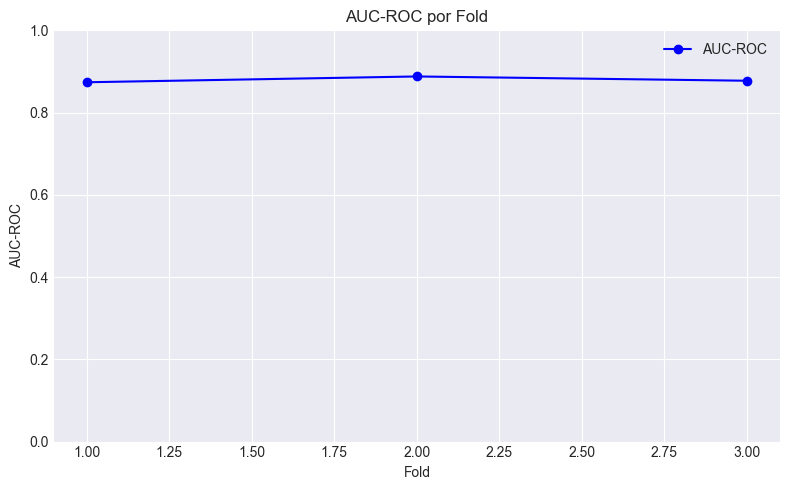

In [15]:


folds = list(range(1, len(auc_scores) + 1))

plt.figure(figsize=(8, 5))
plt.plot(folds, auc_scores, marker='o', linestyle='-', color='blue', label='AUC-ROC')
plt.title('AUC-ROC por Fold')
plt.xlabel('Fold')
plt.ylabel('AUC-ROC')
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

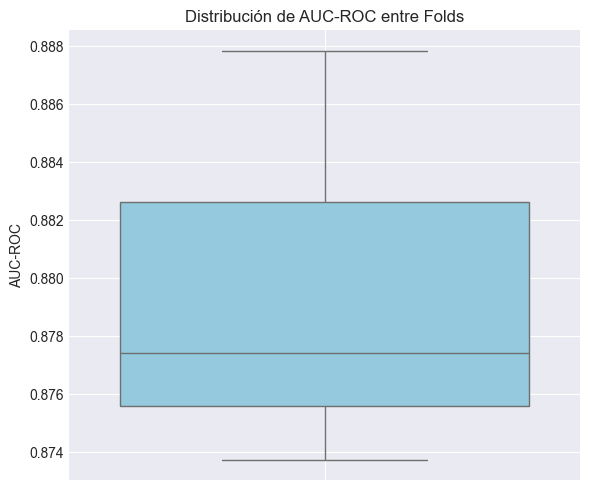

In [16]:
df_auc = pd.DataFrame({'Fold': folds, 'AUC-ROC': auc_scores})

plt.figure(figsize=(6, 5))
sns.boxplot(y='AUC-ROC', data=df_auc, color='skyblue')
plt.title('Distribución de AUC-ROC entre Folds')
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
print(df_auc.describe())

       Fold   AUC-ROC
count   3.0  3.000000
mean    2.0  0.879670
std     1.0  0.007310
min     1.0  0.873741
25%     1.5  0.875587
50%     2.0  0.877432
75%     2.5  0.882635
max     3.0  0.887837


In [18]:
#!pip install scikit-learn

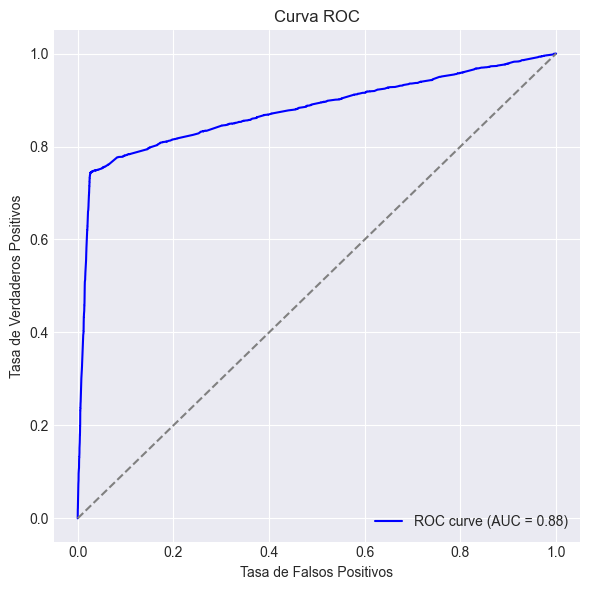

In [27]:
# Supón que tienes un DataFrame en PySpark con predicciones

from sklearn.metrics import roc_curve, auc

df_spark = predictions.select("prediction", "probability", "DelayedFlag")

# Convertir a Pandas
df_pandas = df_spark.toPandas()

# Supón que tienes las predicciones convertidas a pandas
y_true = df_pandas["DelayedFlag"]
y_scores = df_pandas["probability"].apply(lambda x: x[1])  # probabilidad clase 1

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

final_feature_names = numeric_features.copy()

# Suponemos que los encoders están en las posiciones correctas del pipeline
for encoder in preprocessing_model.stages[len(categorical_features):len(categorical_features)*2]:
    input_col = encoder.getInputCol().replace("_indexed", "")
    num_categories = encoder.categorySizes[0]
    
    # Restar 1 por dropLast=True
    final_feature_names.extend([f"{input_col}_{i}" for i in range(num_categories - 1)])


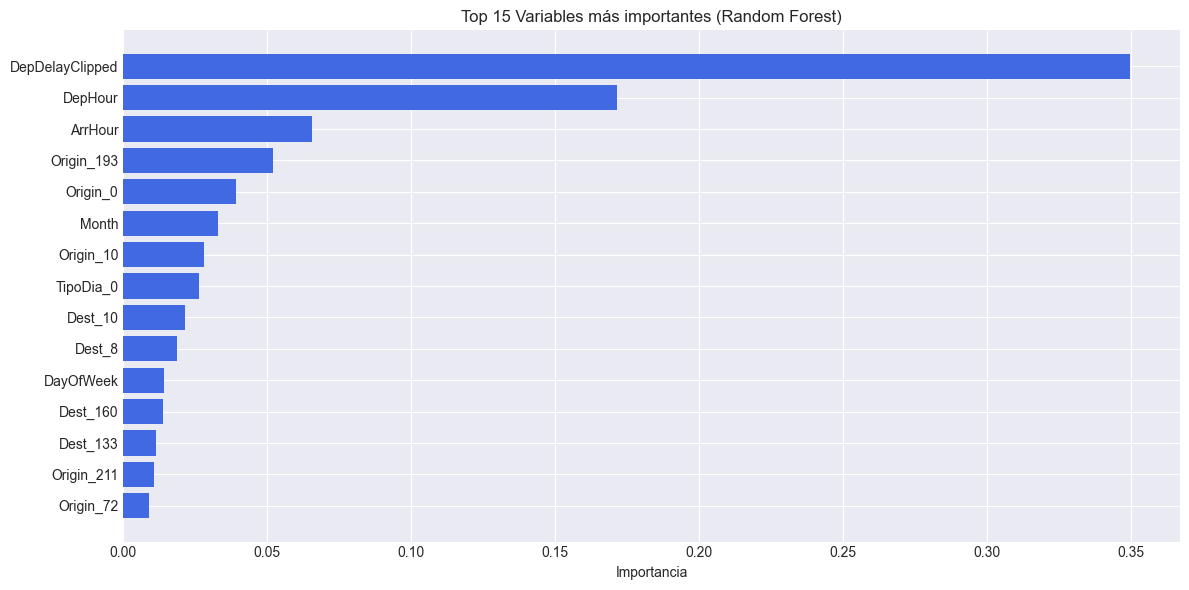

In [26]:
# Obtener las importancias del modelo
importances = best_model.featureImportances.toArray()

# Verificación de tamaños
assert len(importances) == len(final_feature_names), \
    f"Las dimensiones no coinciden: {len(importances)} importancias vs {len(final_feature_names)} nombres"

# Crear DataFrame
importance_df = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualización
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15], color='royalblue')
plt.xlabel('Importancia')
plt.title('Top 15 Variables más importantes (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# **5. Discusión de resultados y Conclusiones.**

**Objetivo:**

*En esta última sección, deberás de realizar un análisis de los resultados obtenidos de acuerdo a la tarea de aprendizaje que te has planteado en tu proyecto, de tal forma que se analice que tan significativos son los resultados obtenidos, la variabilidad que se obtuvo en los experimentos, para poder determinar qué tan significativos son estos resultados de acuerdo a la tarea de aprendizaje plantada. Lo anterior deberás de plasmarlo en una sección de tu Jupyter Notebook con título “Discusión y conclusiones”.*

Durante ésta actividad, se realizó la técnica de validación cruzada con k = 3, valor seleccionado previamente con el objetivo de evaluar la variabilidad en el desempeño del modelo. La elección de k se basó en el tamaño de la muestra y en la necesidad de que cada fold fuera representativo de la población original, asegurando una distribución similar de las variables de caracterización en cada partición. Cabe destacar que esta técnica no se utilizó para el ajuste de hiperparámetros, sino para validar la estabilidad y la capacidad de generalización del modelo frente a diferentes subconjuntos de datos.

Ahora bien, de acuerdo a los datos obtenidos en el `AUC-ROC`, los valores obtenidos en los 3 Folds están por encima de 0.87, lo cual indica que el modelo tiene una muy buena capacidad de discriminación entre clases (en este caso, entre vuelos retrasados y no retrasados), además de una buena **estabilidad y generalización del modelo**, pues en todos los resultados hemos obtenido resultados muy similares, con apenas 0.0238 puntos porcentuales de variación. 

Finalmente, se identificaron las variables con mayor aporte al desempeño del modelo, destacándose DepDelayClipped, ArrHour, DepHour y Temporada_1. Esto sugiere que los retrasos previos en la salida (DepDelayClipped) y el momento del día en que se realiza la llegada y salida (ArrHour y DepHour) son factores determinantes para predecir el retraso de vuelos. Además, la variable Temporada_1 indica que la estacionalidad o periodo del año también influye significativamente en la probabilidad de retrasos. Estos hallazgos son consistentes con la intuición operativa y refuerzan la importancia de considerar tanto variables temporales como históricas en la modelación de retrasos aéreos.


# **Referencias:**

* **James, G., Witten, D., Hastie, T., & Tibshirani, R. (2023)**. An introduction to statistical learning: With applications in Python (1st ed.). Springer. https://www.statlearning.com

* **Pramoditha, R. (2020, diciembre 19)**. K-fold cross-validation explained in plain English. Towards Data Science. https://towardsdatascience.com/k-fold-cross-validation-explained-in-plain-english-659e33c0bc0